<font size="+3"><strong>4.2. Predicting Damage with Logistic Regression</strong></font>

In [4]:
import sqlite3

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from category_encoders import OneHotEncoder
from IPython.display import VimeoVideo
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils.validation import check_is_fitted

## Import

In [24]:
def wrangle(filepath):
    # Connect to database
    # conn = sqlite3.connect(db_path)

    # Construct query
    # query = """
    #     SELECT distinct(i.building_id) AS b_id,
    #        s.*,
    #        d.damage_grade
    #     FROM id_map AS i
    #     JOIN building_structure AS s ON i.building_id = s.building_id
    #     JOIN building_damage AS d ON i.building_id = d.building_id
    #     WHERE district_id = 4
    # """

    # Read query results into DataFrame
    df = pd.read_csv(filepath , index_col="b_id")
    
    # Identify leaky columns
    drop_cols = [col for col in df.columns if "post_eq" in col]
    
    
    # Create binary target
    df["damage_grade"] = df["damage_grade"].str[-1].astype(int)
    df["severe_damage"] = (df["damage_grade"] > 3).astype(int)

    # Drop old target
    drop_cols.append("damage_grade")
    
    # Drop multicollinearity column
    drop_cols.append("count_floors_pre_eq")
    
    # Drop high-cardinality catagorical column
    drop_cols.append("building_id")
    
    # Drop columns
    df.drop(columns=drop_cols, inplace=True)

    return df

**Task 4.2.1:** Complete the `wrangle` function above so that the it returns the results of `query` as a DataFrame. Be sure that the index column is set to `"b_id"`. Also, the path to the SQLite database is `"/home/jovyan/nepal.sqlite"`.


In [25]:
df = wrangle("../data/raw/kavrepalanchok_raw.csv")
df.head()

,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,severe_damage
b_id,,,,,,,,,,,,
87473,15,382,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1
87479,12,328,7,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,"Stone, mud mortar",1
87482,23,427,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1
87491,12,427,14,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1
87496,32,360,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1


**Task 4.2.2:** Add to your wrangle function so that these features are dropped from the DataFrame. Don't forget to rerun all the cells above. 

**Task 4.2.3:** Add to your wrangle function so that it creates a new target column `"severe_damage"`. For buildings where the `"damage_grade"` is Grade 4 or above, `"severe_damage"` should be `1`. For all other buildings, `"severe_damage"` should be `0`. Don't forget to drop `"damage_grade"` to avoid leakage, and rerun all the cells above.


**Task 4.2.4:** Plot a correlation heatmap of the remaining numerical features in `df`. Since `"severe_damage"` will be your target, you don't need to include it in your heatmap. 


<Axes: >

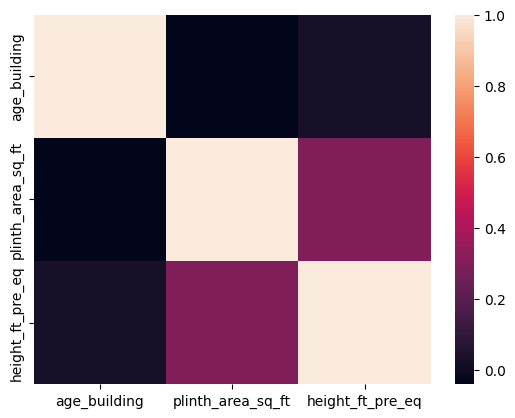

In [26]:
# Create correlation matrix
correlation = df.select_dtypes("number").drop(columns="severe_damage").corr()
correlation
# Plot heatmap of `correlation`
sns.heatmap(correlation)

**Task 4.2.5:** Change `wrangle` function so that it drops the `"count_floors_pre_eq"` column. Don't forget to rerun all the cells above. 


**Task 4.2.6:** Use seaborn to create a boxplot that shows the distributions of the `"height_ft_pre_eq"` column for both groups in the `"severe_damage"` column. Remember to label your axes. 


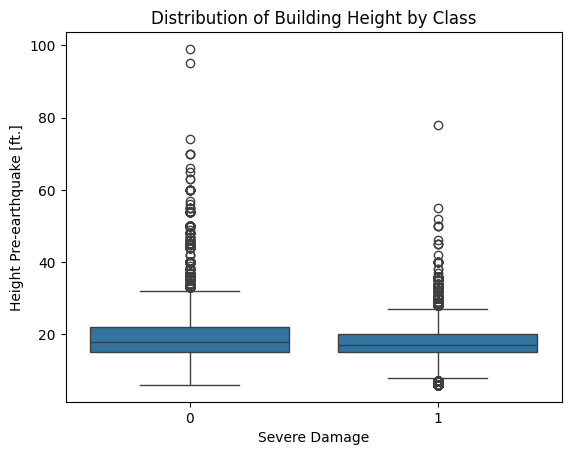

In [27]:
# Create boxplot
sns.boxplot(x="severe_damage", y="height_ft_pre_eq", data=df)
# Label axes
plt.xlabel("Severe Damage")
plt.ylabel("Height Pre-earthquake [ft.]")
plt.title("Distribution of Building Height by Class");

**Task 4.2.7:** Create a bar chart of the value counts for the `"severe_damage"` column. You want to calculate the relative frequencies of the classes, not the raw count, so be sure to set the `normalize` argument to `True`.


<Axes: title={'center': 'Class Balance'}, xlabel='Class', ylabel='Relative Frequency'>

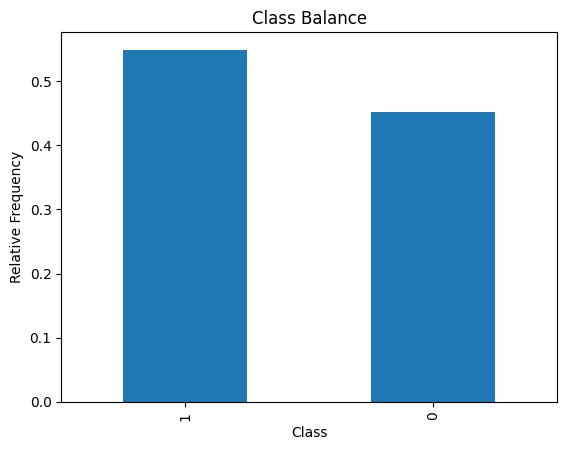

In [28]:
# Plot value counts of `"severe_damage"`
df["severe_damage"].value_counts(normalize=True).plot(
    kind="bar", xlabel="Class", ylabel="Relative Frequency", title="Class Balance"
)

**Task 4.2.8:** Create two variables, `majority_class_prop` and `minority_class_prop`, to store the normalized value counts for the two classes in `df["severe_damage"]`. 


In [29]:
majority_class_prop, minority_class_prop = df["severe_damage"].value_counts(normalize=True)
print(majority_class_prop, minority_class_prop)

0.5487044804202109 0.4512955195797891


**Task 4.2.9:** Are buildings with certain foundation types more likely to suffer severe damage? Create a pivot table of `df` where the index is `"foundation_type"` and the values come from the `"severe_damage"` column, aggregated by the mean.


In [30]:
# Create pivot table
foundation_pivot = pd.pivot_table(
    df, index="foundation_type", values="severe_damage", aggfunc=np.mean
).sort_values(by="severe_damage")
foundation_pivot

C:\Users\Coop\AppData\Local\Temp\ipykernel_20508\1389153726.py:2: FutureWarning: The provided callable <function mean at 0x000001EF5E456160> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  foundation_pivot = pd.pivot_table(


,severe_damage
foundation_type,
RC,0.010378
Bamboo/Timber,0.277680
Cement-Stone/Brick,0.285104
Other,0.322430
Mud mortar-Stone/Brick,0.603319


**Task 4.2.10:** How do the proportions in `foundation_pivot` compare to the proportions for our majority and minority classes? Plot `foundation_pivot` as horizontal bar chart, adding vertical lines at the values for `majority_class_prop` and `minority_class_prop`.


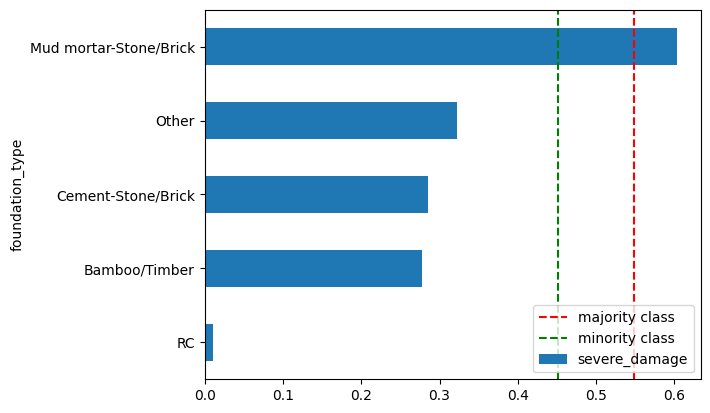

In [31]:
# Plot bar chart of `foundation_pivot`
foundation_pivot.plot(kind="barh", legend=None);
plt.axvline(
    majority_class_prop, linestyle="--", color="red", label="majority class"
)

plt.axvline(
    minority_class_prop, linestyle="--", color="green", label="minority class"
)

plt.legend(loc="lower right")

**Task 4.2.11:** Combine the [`select_dtypes`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.select_dtypes.html) and [`nunique`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.nunique.html) methods to see if there are any high- or low-cardinality categorical features in the dataset. 


In [32]:
# Check for high- and low-cardinality categorical features
df.select_dtypes("object").nunique()
df.head()

,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,severe_damage
b_id,,,,,,,,,,,,
87473,15,382,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1
87479,12,328,7,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,"Stone, mud mortar",1
87482,23,427,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1
87491,12,427,14,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1
87496,32,360,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1


**Task 4.2.12:** Create your feature matrix `X` and target vector `y`. Your target is `"severe_damage"`. 

In [33]:
target = "severe_damage"
X = df.drop(columns=['severe_damage'])  # Features (all columns except 'Target')
y = df[target]

**Task 4.2.13:** Divide your data (`X` and `y`) into training and test sets using a randomized train-test split. Your test set should be 20% of your total data. And don't forget to set a `random_state` for reproducibility. 


In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.2, random_state=42
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (61226, 11)
y_train shape: (61226,)
X_test shape: (15307, 11)
y_test shape: (15307,)


**Task 4.2.14:** Calculate the baseline accuracy score for your model.


In [35]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.55


**Task 4.2.15:** Create a pipeline named `model` that contains a `OneHotEncoder` transformer and a `LogisticRegression` predictor. Be sure you set the `use_cat_names` argument for your transformer to `True`. Then fit it to the training data. 


In [36]:
# Build model
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    LogisticRegression(max_iter=1000)
)
# Fit model to training data
model.fit(X_train, y_train)

d:\pro\Earthquake-Damage-in-Nepal\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['land_surface_condition',
                                     'foundation_type', 'roof_type',
                                     'ground_floor_type', 'other_floor_type',
                                     'position', 'plan_configuration',
                                     'superstructure'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

**Task 4.2.16:** Calculate the training and test accuracy scores for your models. 


In [37]:
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_test = model.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 2))
print("Test Accuracy:", round(acc_test, 2))

Training Accuracy: 0.65
Test Accuracy: 0.65


**Task 4.2.17:** Instead of using the `predict` method with your model, try `predict_proba` with your training data. How does the `predict_proba` output differ than that of `predict`? What does it represent?

In [38]:
model.predict(X_train)[:5]

array([1, 1, 1, 1, 1])